# Exploring top2vec

## Setup

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../../04_dataset_access/"))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
import evaluation
from dataloader import Dataloader

Note: At the time of this writing, the most recent version of top2vec is not yet compatible with sklearn 1.2, requiring a patch at line 581:

```python
words = vectorizer.get_feature_names_out()
```

In [2]:
import pandas as pd
import multiprocessing
from top2vec import Top2Vec
from itertools import repeat, chain

import seaborn as sns
import matplotlib.pyplot as plt

import gensim

In [3]:
df = pd.read_csv(
    "../../24212003_requirements_for_artificial_intelligence/patched_feedbacks.csv"
)
df = Dataloader("page").from_folder(
    "../../24212003_requirements_for_artificial_intelligence/attachments/", df
)

assert len(df) == 2282 + 299 - 13
df.head(2)

As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!
As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!


,id,text,language,country,user_type,organization,surname,feedback,status,company_size,...,publication,publication_id,publication_status,tr_number,scope,governance_level,full_name,source,language_detected,tokenized
0,2665651,Equinet welcomes the opportunity to provide co...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equinet, welcome, the, opportunity, to, provi..."
1,2665651,Equinet’s feedback to the European Commission'...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equinet, feedback, to, the, european, commiss..."


In [4]:
languages = ["ar", "zh", "en", "fr", "de", "it", "ja", "ko", "nl", "pl", "pt", "es"]
languages += ["th", "tr", "ru"]
df = df.query("language_detected.isin(@languages) and tokenized.str.len() > 0")

## Creating the model

In [5]:
model = Top2Vec(
    documents=df["text"].to_list(),
    embedding_model="universal-sentence-encoder-multilingual",
    speed="learn",
    workers=multiprocessing.cpu_count(),
)

2022-12-18 19:30:15,285 - top2vec - INFO - Pre-processing documents for training
/home/felix/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2022-12-18 19:30:16,561 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2022-12-18 19:30:17,911 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-12-18 19:30:21,066 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-12-18 19:30:28,796 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-12-18 19:30:28,829 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


## Visualizing results

### Default wordclouds

In [6]:
for topic in range(model.get_num_topics()):
    model.generate_topic_wordcloud(topic)
    plt.savefig(
        f"../images/top2vec_wordcloud_{str(topic).zfill(2)}.pdf", bbox_inches="tight"
    )
    plt.close()

In [7]:
if os.path.isfile("../images/top2vec_wordcloud.pdf"):
    os.remove("../images/top2vec_wordcloud.pdf")
files = sorted(
    [
        "../images/" + f
        for f in os.listdir("../images")
        if f.startswith("top2vec_wordcloud")
    ]
)
evaluation.merge_pdfs(files, "../images/top2vec_wordcloud.pdf")

### Custom barplots

In [8]:
topics_words, word_scores, topic_nums = model.get_topics()

In [9]:
topics = pd.DataFrame(
    dict(
        token=topics_words.reshape(-1),
        score=word_scores.reshape(-1),
        topic=chain(
            *[repeat(i, topics_words.shape[1]) for i in range(topics_words.shape[0])]
        ),
        rank=chain(
            *[range(topics_words.shape[1]) for i in range(topics_words.shape[0])]
        ),
    )
)
topics.head(3)

,token,score,topic,rank
0,european,0.188026,0,0
1,proposal,0.184569,0,1
2,proposals,0.183042,0,2


/home/felix/.local/lib/python3.10/site-packages/seaborn/categorical.py:3202: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


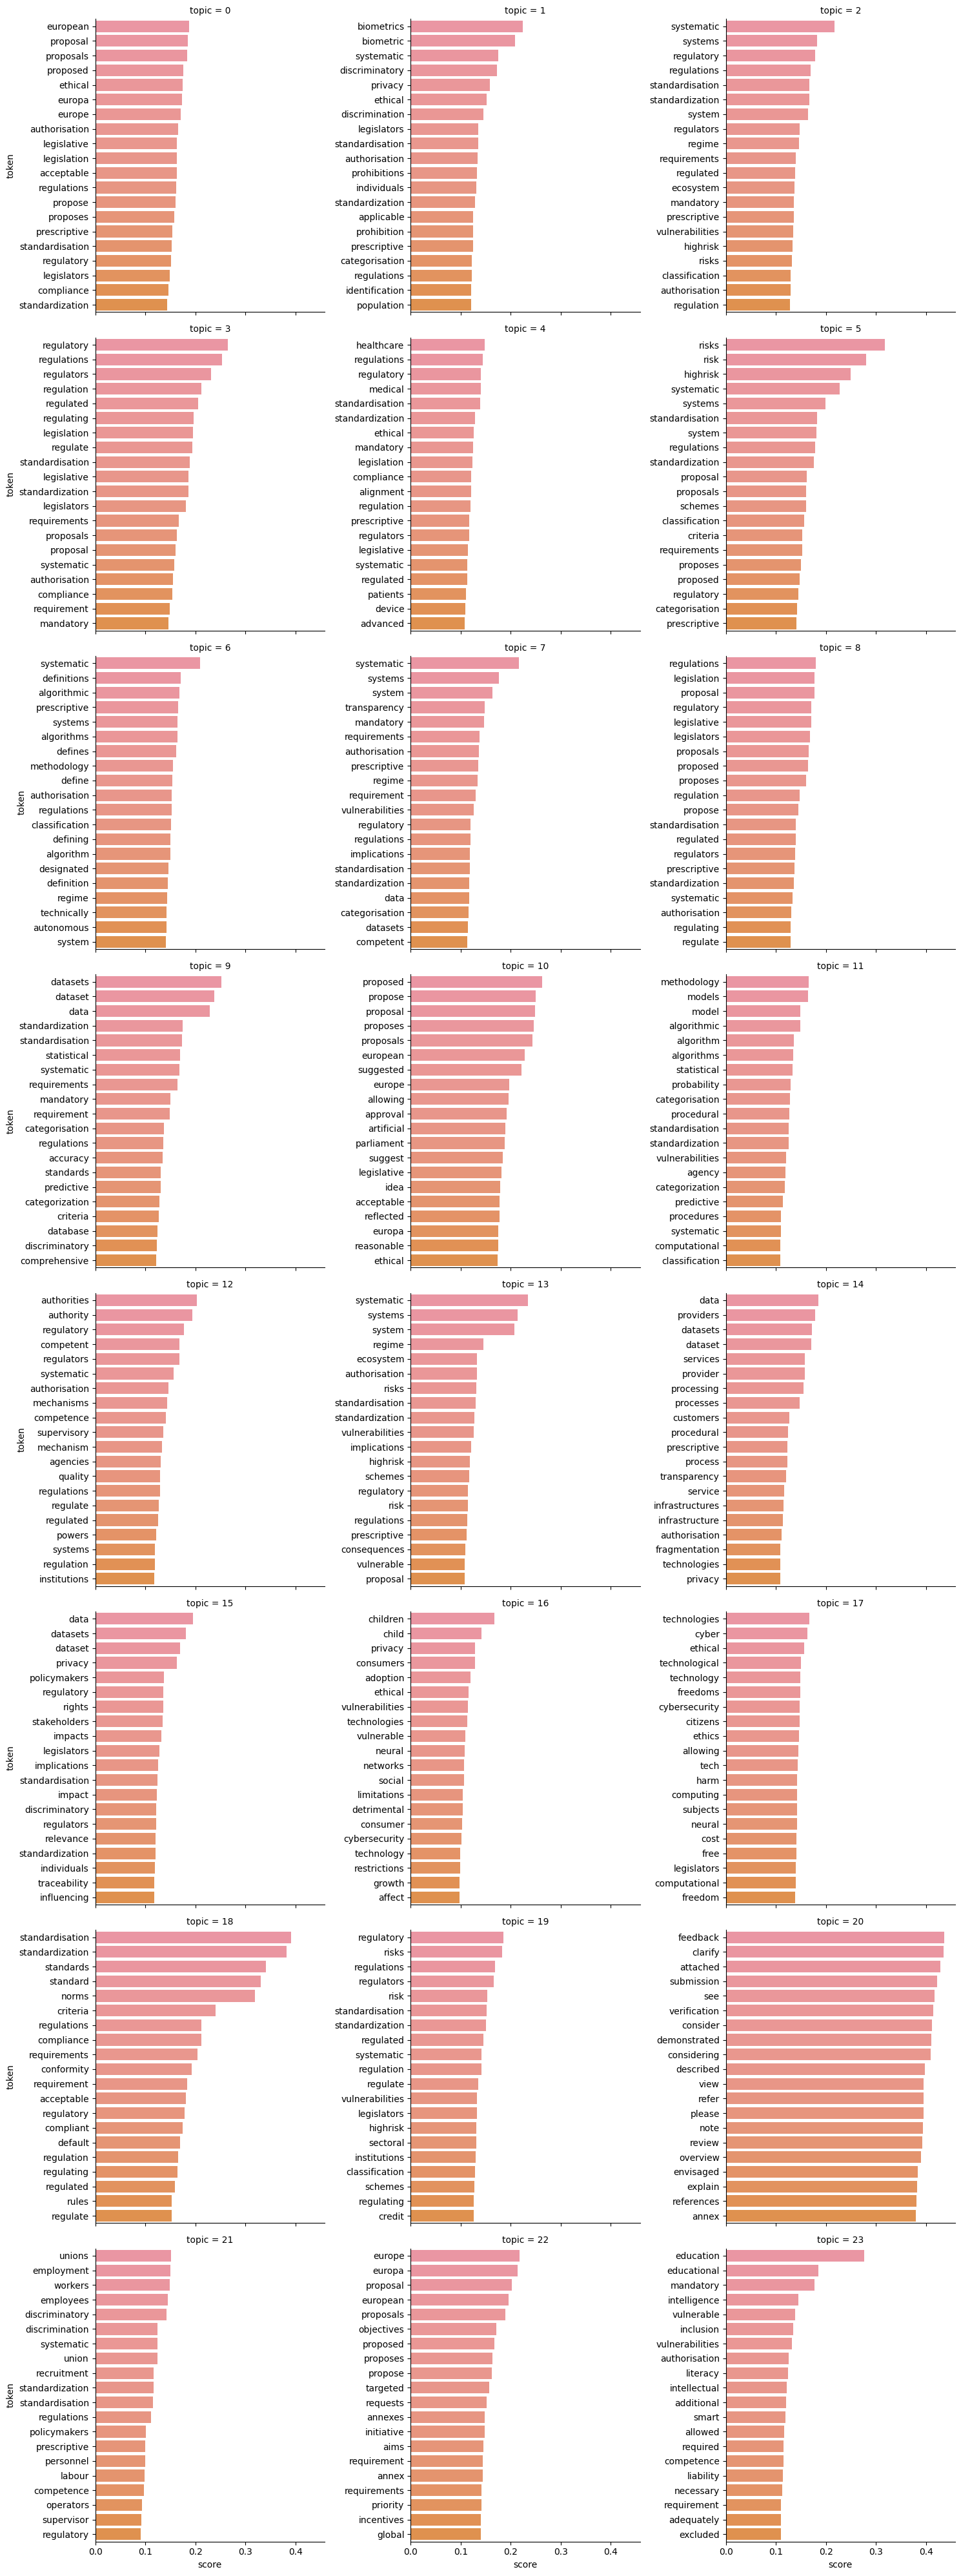

In [10]:
s = sns.catplot(
    x="score",
    y="token",
    data=topics.query("rank < 20"),
    kind="bar",
    sharey=False,
    col="topic",
    col_wrap=3,
)
s.fig.savefig("../images/top2vec_topics.pdf", bbox_inches="tight")

## Topic coherence

In [11]:
texts = df["tokenized"]
dictionary = gensim.corpora.dictionary.Dictionary(texts)

cm = gensim.models.CoherenceModel(
    topics=topics_words[:, :20].tolist(),
    texts=texts,
    dictionary=dictionary,
    coherence="c_v",
)
f"C_V: {round(cm.get_coherence(), 2)}"

'C_V: 0.4'

## Investigating washed out topics

In [12]:
def relevant_for_topics(term):
    tt = topics.query("token.str.contains(@term) and rank <= 5")["topic"].value_counts()
    return tt.index[tt >= 2]


def plot_relevant_topics(term):
    relevant_topics = relevant_for_topics(term)
    sns.catplot(
        x="score",
        y="token",
        data=topics.query("topic.isin(@relevant_topics) and rank < 20"),
        kind="bar",
        sharey=False,
        col="topic",
        col_wrap=4,
    )

### Risk

/home/felix/.local/lib/python3.10/site-packages/seaborn/categorical.py:3202: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


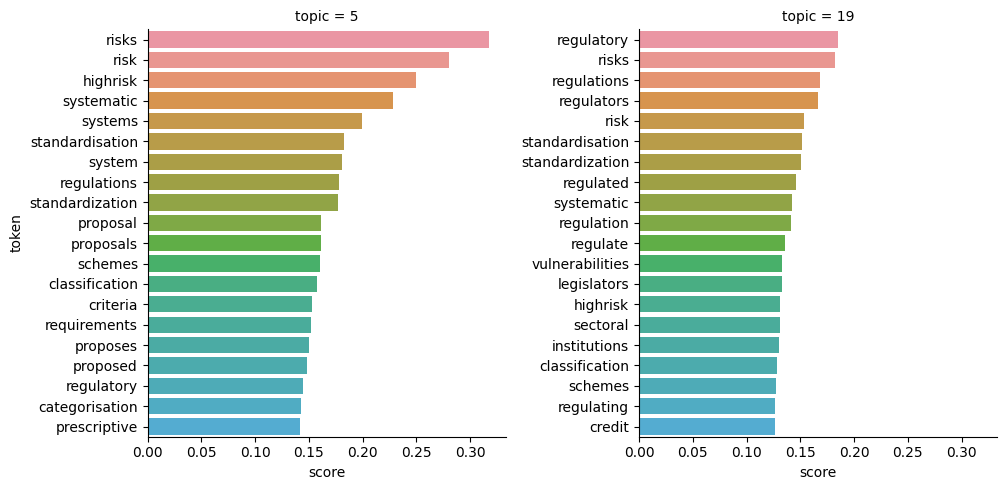

In [13]:
plot_relevant_topics("risk")

### Regulation

/home/felix/.local/lib/python3.10/site-packages/seaborn/categorical.py:3202: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


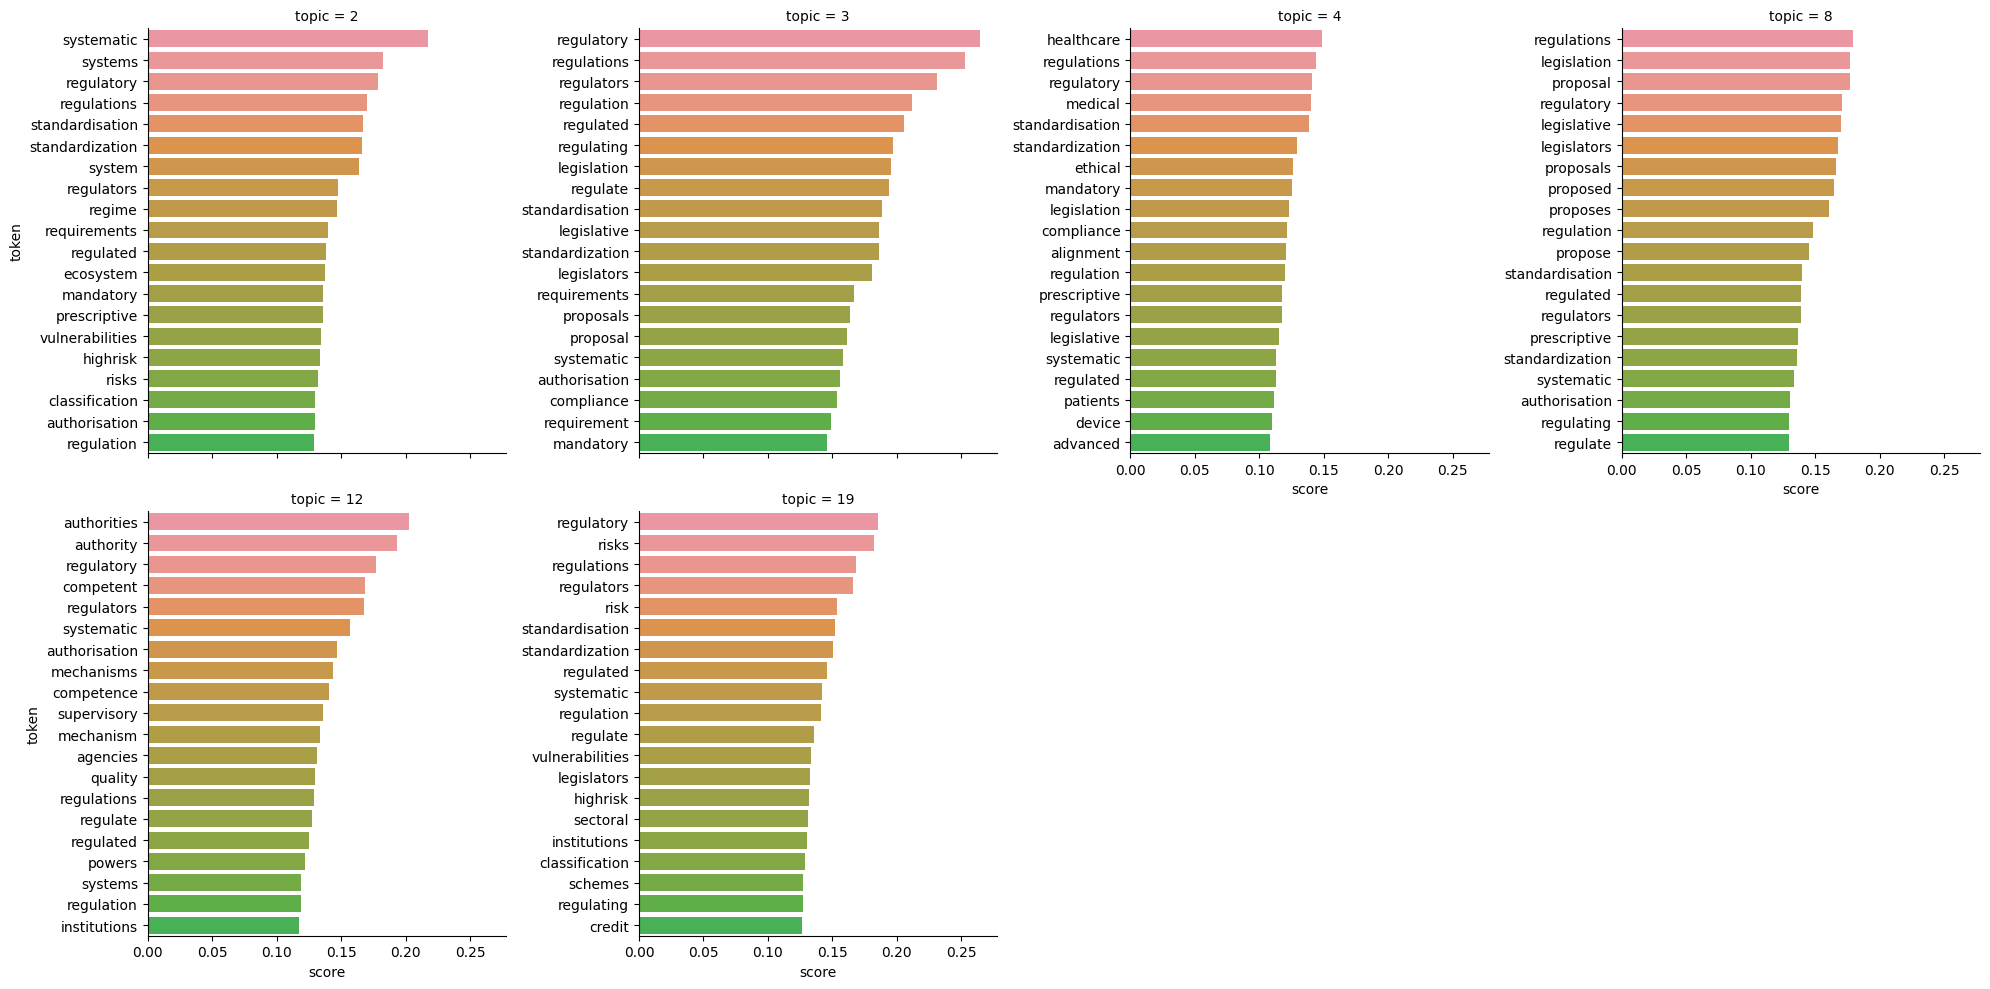

In [14]:
plot_relevant_topics("regul")

## Saving the model

In [15]:
model.save("final_model.pkl")